In [105]:

import os
from collections import OrderedDict

import numpy as np
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

from scipy.optimize import minimize
from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from utils.vibe.basic_vibe_preprocessing import load_vibe_data, process_vibe_joints, convert_to_lafan1_style, rotate_to_z_up, PARENTS
from utils.lafan1.calc_utils import quat_inv, quat_mul, quat_mul_vec, quat_normalize, quat_fk, quat_ik, quat_between

In [106]:
PATH = './data/blanket_occlusion.pkl'
DATA = './DATA'
LAFAN = os.path.join(DATA, 'curr_lafan_sample.npy')
data0 = load_vibe_data(PATH, 0)
motion_data, _, _ = data0
lafan_data = np.load(LAFAN, allow_pickle=True).item()
# Extract LaFAN1-style motion dataset
processed_joints = process_vibe_joints(motion_data) 
lafan1_motion_raw, parents = convert_to_lafan1_style(processed_joints)
lafan_rot = lafan_data['rotations'].squeeze().numpy()
lafan1_motion_raw.shape, lafan_rot.shape


Up vector: [-0.003340 0.943365 -0.029797]
Dot products with axes: [0.003340 0.943365 0.029797]
Selected axis: 1 (y)
Sign: 1


((700, 22, 3), (65, 22, 4))

In [107]:
FRAME_SELECT = 33
JOINT_SELECT = 7
check_vibe_pos = lafan1_motion_raw[FRAME_SELECT, JOINT_SELECT,:]
check_vibe_pos_t = lafan1_motion_raw[:, JOINT_SELECT,:]



In [108]:
lafan_rot

array([[[0.184117, -0.747290, -0.634357, 0.072451],
        [-0.127548, -0.468753, -0.866562, -0.114334],
        [0.446293, -0.003305, 0.065225, -0.892501],
        ...,
        [0.882355, -0.003550, -0.360404, -0.302566],
        [0.793150, 0.061141, 0.120114, -0.593926],
        [0.973684, -0.207205, 0.093029, -0.018723]],

       [[0.178535, -0.744828, -0.640041, 0.060867],
        [-0.118473, -0.500163, -0.852637, -0.093871],
        [0.441379, 0.001866, 0.052827, -0.895763],
        ...,
        [0.879483, -0.010980, -0.351881, -0.320264],
        [0.803656, 0.061456, 0.123832, -0.578813],
        [0.975501, -0.198779, 0.092464, -0.018284]],

       [[0.172461, -0.742333, -0.645642, 0.048429],
        [-0.109330, -0.529346, -0.838289, -0.071487],
        [0.452183, 0.011733, 0.029884, -0.891347],
        ...,
        [0.877482, -0.021782, -0.337573, -0.339993],
        [0.814221, 0.061367, 0.127255, -0.563103],
        [0.978103, -0.187500, 0.088297, -0.018996]],

       ...,

  

In [109]:
check_vibe_pos_t, check_vibe_pos_t.shape #as expected (700,3)

(array([[0.013472, -0.638811, 0.035019],
        [0.008985, -0.646023, 0.041877],
        [0.005273, -0.652381, 0.045386],
        ...,
        [-0.287597, -0.167491, -0.541395],
        [-0.346161, -0.063283, -0.742170],
        [-0.151143, -0.346274, -0.406683]]),
 (700, 3))

In [110]:
def compute_vibe_local_pose(vibe_raw_gpos, ref_local_rot = None, parents=PARENTS):
    
    #hard-coded
    num_joints = len(parents)
    vibe_lpos = vibe_raw_gpos.copy()

    # root gpos becomes lpos
    assert vibe_lpos[0,0,0] == vibe_raw_gpos[0,0,0]
    
    #only require first frame? (check..)
    FIRST_FRAME, ROOT = 0, 0
    # iterating over skeleton tree 
    local_pos_dict = np.zeros((len(parents),3))
    local_pos_dict[0] = vibe_raw_gpos[FIRST_FRAME,ROOT,:]
    for j in range(1, num_joints):
        print(f"Processing joint j : {j}")
        parent = parents[j]
        if parent != -1:
            offset_from_parent = vibe_raw_gpos[FIRST_FRAME,j,:] - vibe_raw_gpos[FIRST_FRAME,parent,:]
            print(f"Offset from parents: {offset_from_parent} its shape: {offset_from_parent.shape}")
            rot = ref_local_rot[FIRST_FRAME, j, :] # (To-Do) Lafan1과 VIBE 조인트 완전히 일치하는지 모르겠음..
            print(f"rotation from Lafan1 {rot}")
            rot_inv = quat_inv(rot) #q^-1
            print(f"rotation inverse: {rot_inv}")
            estimated_local_pos = quat_mul_vec(rot_inv, offset_from_parent)
            print(f"estimated_local_pos: {estimated_local_pos}")
            local_pos_dict[j] = estimated_local_pos
            
    
    return local_pos_dict, ref_local_rot[FIRST_FRAME, :, :]


def visualize_skeleton_comparison(original_pos, reconstructed_pos, parents):
    """
    Visualize original and reconstructed skeletons side by side
    """
    # Make sure input is the right shape - remove batch dimension if present
    if len(original_pos.shape) == 3:
        original_pos = original_pos[0]
    if len(reconstructed_pos.shape) == 3:
        reconstructed_pos = reconstructed_pos[0]
        
    # Create figure and 3D axes
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Plot original skeleton
    ax1.set_title('Original')
    ax1.scatter(original_pos[:, 0], original_pos[:, 1], original_pos[:, 2], c='black', s=15)
    
    # Plot bones
    for j in range(1, len(parents)):
        parent = parents[j]
        if parent != -1:
            x = [original_pos[parent, 0], original_pos[j, 0]]
            y = [original_pos[parent, 1], original_pos[j, 1]]
            z = [original_pos[parent, 2], original_pos[j, 2]]
            ax1.plot(x, y, z, 'r-')
    
    # Plot reconstructed skeleton
    ax2.set_title('Reconstructed')
    ax2.scatter(reconstructed_pos[:, 0], reconstructed_pos[:, 1], reconstructed_pos[:, 2], c='black', s=15)
    
    # Plot bones
    for j in range(1, len(parents)):
        parent = parents[j]
        if parent != -1:
            x = [reconstructed_pos[parent, 0], reconstructed_pos[j, 0]]
            y = [reconstructed_pos[parent, 1], reconstructed_pos[j, 1]]
            z = [reconstructed_pos[parent, 2], reconstructed_pos[j, 2]]
            ax2.plot(x, y, z, 'b-')
    
    # Set equal aspect ratio
    max_range = 0
    for ax in [ax1, ax2]:
        xs = ax.get_xlim3d()
        ys = ax.get_ylim3d()
        zs = ax.get_zlim3d()
        max_range = max(max_range, max([abs(max(xs) - min(xs)), 
                                        abs(max(ys) - min(ys)), 
                                        abs(max(zs) - min(zs))]))
        
    # Set limits for equal scaling
    for ax in [ax1, ax2]:
        mid_x = (ax.get_xlim3d()[1] + ax.get_xlim3d()[0]) / 2
        mid_y = (ax.get_ylim3d()[1] + ax.get_ylim3d()[0]) / 2
        mid_z = (ax.get_zlim3d()[1] + ax.get_zlim3d()[0]) / 2
        ax.set_xlim3d([mid_x - max_range/2, mid_x + max_range/2])
        ax.set_ylim3d([mid_y - max_range/2, mid_y + max_range/2])
        ax.set_zlim3d([mid_z - max_range/2, mid_z + max_range/2])
    
    plt.tight_layout()
    plt.savefig('skeleton_comparison.png')  # Save the visualization
    plt.close()  # Close the plot to prevent display issues


In [111]:
def compute_local_transform_from_global(global_pos, parents):
    """
    Compute local positions and rotations that would reproduce the global positions
    when fed through forward kinematics.
    """
    num_frames, num_joints, _ = global_pos.shape
    local_pos = np.zeros_like(global_pos)
    local_rot = np.zeros((num_frames, num_joints, 4))
    
    # Set root local position to global position
    local_pos[:, 0, :] = global_pos[:, 0, :]
    
    # Root rotation (identity quaternion)
    local_rot[:, 0, 0] = 1.0
    
    # Global rotations and positions that will be computed
    global_rot = np.zeros((num_frames, num_joints, 4))
    global_rot[:, 0, 0] = 1.0  # Root global rotation is identity
    
    # Process joints in hierarchy order (starting from root)
    for j in range(1, num_joints):
        parent = parents[j]
        if parent != -1:
            # Compute bone direction in global space
            direction = global_pos[:, j, :] - global_pos[:, parent, :]
            direction_norm = np.linalg.norm(direction, axis=-1, keepdims=True)
            direction = direction / (direction_norm + 1e-8)
            
            # For each frame, compute rotation that aligns canonical direction with actual direction
            for f in range(num_frames):
                # Canonical direction (could be [0,0,1] or another direction depending on your skeleton)
                canonical = np.array([0, 0, 1])
                
                # Current global direction
                current = direction[f]
                
                # Compute rotation between canonical and current
                # Using axis-angle representation
                dot = np.dot(canonical, current)
                
                if dot > 0.9999:
                    # Vectors are nearly parallel
                    global_rot[f, j] = np.array([1, 0, 0, 0])  # Identity quaternion
                elif dot < -0.9999:
                    # Vectors are nearly opposite
                    axis = np.array([1, 0, 0])  # Any perpendicular axis
                    global_rot[f, j] = np.array([0, axis[0], axis[1], axis[2]])  # 180° rotation
                else:
                    # Cross product gives rotation axis
                    axis = np.cross(canonical, current)
                    axis = axis / np.linalg.norm(axis)
                    
                    # Compute rotation angle
                    angle = np.arccos(dot)
                    
                    # Convert to quaternion
                    global_rot[f, j, 0] = np.cos(angle/2)
                    global_rot[f, j, 1:] = axis * np.sin(angle/2)
            
            # Compute local rotation (relative to parent)
            parent_inv_rot = quat_inv(global_rot[:, parent, :])
            local_rot[:, j, :] = quat_mul(parent_inv_rot, global_rot[:, j, :])
            
            # Compute local position
            for f in range(num_frames):
                offset = global_pos[f, j, :] - global_pos[f, parent, :]
                local_pos[f, j, :] = quat_mul_vec(quat_inv(global_rot[f, parent, :]), offset)
    
    return local_pos, local_rot

In [112]:
def rotate(motion, order='zxy'):
    axis_order_map = {'x':0, 'y':1, 'z':2}
    permute= [axis_order_map[axis] for axis in order]    

    res_motion = motion[...,permute]
    # print(motion[0,0,...])
    # print(res_motion[0,0,...])
    
    return res_motion

def reconstruct(local_pos, vibe_raw_gpos, ref_local_rot, parents=PARENTS):
    #reconstruct 0 frame..check

    local_pos = local_pos[None]
    ref_local_rot= ref_local_rot[None]


    print(ref_local_rot.shape, "ref_local_rot ")
    print(local_pos.shape, "local rot obtained from : compute_vibe_local_pose")

    grot_at0frame, gpos_at0frame = quat_fk(ref_local_rot, local_pos, parents)
    print(f"gpos at 0 frame: {gpos_at0frame} and its shape {gpos_at0frame.shape}")
    print(f"GTpos at 0 frame: {vibe_raw_gpos} and its shape {vibe_raw_gpos.shape}")


def test_local_transform(scaled_motion_data, parents):
    """
    Test the local transform and reconstruction
    """
    # Compute local transform
    local_pos, local_rot = compute_local_transform_from_global(scaled_motion_data, parents)
    
    # Reconstruct global positions
    global_rot, global_pos = quat_fk(local_rot, local_pos, parents)
    
    # Print error statistics
    error = np.linalg.norm(global_pos - scaled_motion_data, axis=-1).mean()
    print(f"Average reconstruction error: {error}")
    
    # Visualize first frame
    visualize_skeleton_comparison(scaled_motion_data[0], global_pos[0], parents)
    
    return local_pos, local_rot, global_pos

def create_constant_offset_rotations(global_pos, parents):
    """
    Create LaFAN1-compatible data with:
    - Constant local positions (from first frame)
    - Varying rotations that reconstruct the original
    """
    num_frames, num_joints, _ = global_pos.shape
    
    # Step 1: Get local positions from first frame using your working solution
    local_pos_first, local_rot_first = compute_local_transform_from_global(global_pos[:1], parents)
    
    # Step 2: Use these constant offsets for all frames
    constant_local_pos = np.tile(local_pos_first, (num_frames, 1, 1))
    
    # Step 3: Initialize output arrays for rotations
    local_rot = np.zeros((num_frames, num_joints, 4))
    local_rot[:, 0, 0] = 1.0  # Identity quaternion for root rotation
    
    # Step 4: Frame by frame, solve for rotations that reconstruct positions
    for frame in range(num_frames):
        # Start with root
        local_rot[frame, 0] = local_rot_first[0, 0]  # Use root rotation from first frame
        
        # Process joints in hierarchy order
        for j in range(1, num_joints):
            parent = parents[j]
            if parent == -1:
                continue
                
            # Get global positions for this joint and its parent
            parent_global = global_pos[frame, parent]
            joint_global = global_pos[frame, j]
            
            # Get local offset for this joint (constant from first frame)
            local_offset = constant_local_pos[0, j]
            
            # Calculate desired global direction (from parent to joint)
            target_direction = joint_global - parent_global
            target_length = np.linalg.norm(target_direction)
            if target_length > 0:
                target_direction /= target_length
            
            # Calculate the current direction if using first frame's rotation
            # First we need parent's global rotation
            parent_global_rot = local_rot[frame, parent].copy()
            for p in range(parent):
                if parents[p] != -1:
                    parent_global_rot = quat_mul(parent_global_rot, local_rot[frame, p])
            
            # Calculate current direction using parent's rotation
            current_direction = quat_mul_vec(parent_global_rot, local_offset)
            current_length = np.linalg.norm(current_direction)
            if current_length > 0:
                current_direction /= current_length
            
            # Calculate rotation to align current with target direction
            rotation = quat_between(current_direction, target_direction)
            
            # Apply rotation to local rotation
            local_rot[frame, j] = quat_mul(rotation, local_rot_first[0, j])
            
            # Normalize quaternion
            local_rot[frame, j] /= np.linalg.norm(local_rot[frame, j])
    
    # Step 5: Verify reconstruction
    test_global_rot, test_global_pos = quat_fk(local_rot, constant_local_pos, parents)
    error = np.linalg.norm(test_global_pos - global_pos, axis=-1).mean()
    print(f"Average reconstruction error: {error}")
    
    return constant_local_pos, local_rot

def two_step_approach(global_pos, parents):
    """
    Two-step approach:
    1. Get constant local offsets from first frame
    2. For each frame, run 10 iterations of optimization to find rotations
       that match the global positions
    """
    num_frames, num_joints, _ = global_pos.shape
    
    # Step 1: Get local positions from first frame
    local_pos_first, _ = compute_local_transform_from_global(global_pos[:1], parents)
    constant_local_pos = np.tile(local_pos_first, (num_frames, 1, 1))
    
    # Step 2: Initialize rotations with identity quaternions
    local_rot = np.zeros((num_frames, num_joints, 4))
    local_rot[:, :, 0] = 1.0  # All identity quaternions
    
    # Step 3: For each frame, optimize rotations
    for frame in range(num_frames):
        # Get target positions for this frame
        target_pos = global_pos[frame]
        
        # Run 10 iterations of optimization
        for iteration in range(10):
            # Get current global positions
            _, current_global_pos = quat_fk(local_rot[frame:frame+1], 
                                          constant_local_pos[frame:frame+1], 
                                          parents)
            current_global_pos = current_global_pos[0]  # Remove batch dimension
            
            # Calculate error vectors
            error_vectors = target_pos - current_global_pos
            
            # For each joint, adjust its rotation to reduce error
            for j in range(1, num_joints):
                parent = parents[j]
                if parent == -1:
                    continue
                
                # Skip if error is small
                joint_error = np.linalg.norm(error_vectors[j])
                if joint_error < 0.01:
                    continue
                
                # Calculate correction rotation
                current_dir = current_global_pos[j] - current_global_pos[parent]
                target_dir = target_pos[j] - current_global_pos[parent]
                
                # Normalize directions
                current_len = np.linalg.norm(current_dir)
                target_len = np.linalg.norm(target_dir)
                if current_len > 0 and target_len > 0:
                    current_dir /= current_len
                    target_dir /= target_len
                    
                    # Find rotation to align directions
                    correction = quat_between(current_dir, target_dir)
                    
                    # Apply correction to local rotation
                    local_rot[frame, j] = quat_mul(correction, local_rot[frame, j])
                    
                    # Normalize quaternion
                    local_rot[frame, j] /= np.linalg.norm(local_rot[frame, j])
    
    # Verify final result
    _, reconstructed_pos = quat_fk(local_rot, constant_local_pos, parents)
    error = np.linalg.norm(reconstructed_pos - global_pos, axis=-1).mean()
    print(f"Final optimization error: {error}")
    
    return constant_local_pos, local_rot, reconstructed_pos

def main():
    # (Experimental Things) give lafan1 first local rot for vibe local rot  
    ref_local_rot = lafan_rot.copy()
    SCALE = 100.0 #Lafan1과 보폭 맞추기..
    rotation = 'xyz'
    scaled_motion_data = rotate(lafan1_motion_raw, rotation) * SCALE
    # temp_res, rot_used =  compute_vibe_local_pose(scaled_motion_data, ref_local_rot) #이제까지 만든 결과물..temp_res
    temp_res, rot_used = compute_local_transform_from_global(scaled_motion_data, parents)

    
    reconstruct(temp_res[0,...], scaled_motion_data[0,...], rot_used[0,...])
    visualize_skeleton_comparison(scaled_motion_data, temp_res, parents)


def newmain():
    # (Experimental Things) give lafan1 first local rot for vibe local rot  
    ref_local_rot = lafan_rot.copy()
    SCALE = 100.0  # Lafan1과 보폭 맞추기..
    rotation = 'xyz'
    scaled_motion_data = rotate(lafan1_motion_raw, rotation) * SCALE

    simple_test = False
    if simple_test:
        # Compute local transform
        local_pos, local_rot = compute_local_transform_from_global(scaled_motion_data, parents)

        
        # Test reconstruction on first frame
        print("Testing first frame reconstruction:")
        frame_idx = 0
        grot, gpos = quat_fk(local_rot[frame_idx:frame_idx+1], local_pos[frame_idx:frame_idx+1], parents)
        
        print(f"Original global positions shape: {scaled_motion_data[frame_idx].shape}")
        print(f"Reconstructed global positions shape: {gpos[0].shape}")
        
        # Calculate error
        error = np.linalg.norm(gpos[0] - scaled_motion_data[frame_idx], axis=1)
        print(f"Joint-wise reconstruction error: {error}")
        print(f"Max error: {error.max()}, Mean error: {error.mean()}")
        
        # Visualize
        visualize_skeleton_comparison(scaled_motion_data[frame_idx], gpos[0], parents)

    constant_local_pos, local_rot, new_global_pos = two_step_approach(scaled_motion_data, parents)
    
    return constant_local_pos, local_rot, new_global_pos



    


local_pos, local_rot, gpos =newmain()
local_rot



Final optimization error: 38.89564223257944


array([[[1.000000, 0.000000, 0.000000, 0.000000],
        [1.000000, 0.000000, 0.000000, 0.000000],
        [0.565583, -0.813671, -0.079275, -0.108493],
        ...,
        [0.228997, -0.844163, 0.324159, 0.360375],
        [0.204163, 0.039670, -0.549671, -0.809077],
        [0.682367, -0.391527, -0.430715, -0.442228]],

       [[1.000000, 0.000000, 0.000000, 0.000000],
        [0.997814, -0.002267, -0.043441, 0.049740],
        [0.591472, -0.752064, -0.021267, -0.290014],
        ...,
        [-0.116568, -0.817690, 0.474064, 0.305056],
        [-0.065203, 0.196190, -0.839394, -0.502669],
        [0.968605, -0.169980, 0.181240, -0.007902]],

       [[1.000000, 0.000000, 0.000000, 0.000000],
        [0.993998, -0.003979, -0.066736, 0.086599],
        [0.584607, -0.692376, 0.020602, -0.422405],
        ...,
        [-0.257952, -0.157548, 0.947948, -0.100171],
        [-0.436278, 0.389304, -0.597462, 0.548765],
        [-0.026440, -0.461124, 0.594406, -0.658291]],

       ...,

       [[

In [114]:
local_pos[:,1,:], local_pos[:,2,:]

(array([[-12.132427, -0.042713, -0.590344],
        [-12.132427, -0.042713, -0.590344],
        [-12.132427, -0.042713, -0.590344],
        ...,
        [-12.132427, -0.042713, -0.590344],
        [-12.132427, -0.042713, -0.590344],
        [-12.132427, -0.042713, -0.590344]]),
 array([[5.191805, -47.760311, -4.039170],
        [5.191805, -47.760311, -4.039170],
        [5.191805, -47.760311, -4.039170],
        ...,
        [5.191805, -47.760311, -4.039170],
        [5.191805, -47.760311, -4.039170],
        [5.191805, -47.760311, -4.039170]]))

NameError: name 'vibe_raw_gpos' is not defined

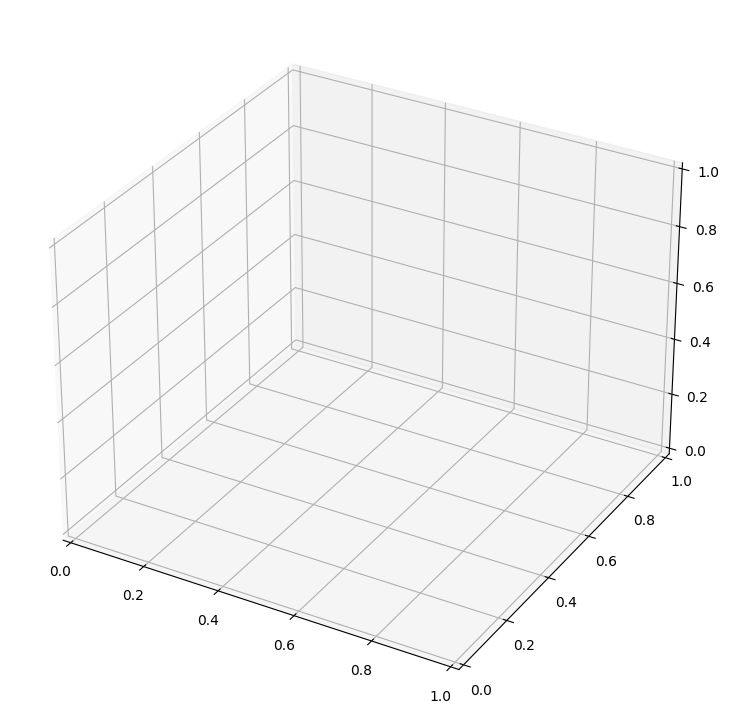

In [48]:
# Setup figure
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121, projection='3d')


min_val = np.min(vibe_raw_gpos)
max_val = np.max(vibe_raw_gpos)
range_val = max_val - min_val
if range_val < 1e-6:  # If range is too small
    print("\nWARNING: Very small position range detected!")
    range_val = 1.0  # Set a default range
mid_val = (max_val + min_val) / 2

def update(frame):
    ax1.clear()
    
    # Common settings
    for ax in [ax1]:
        ax.set_xlim(mid_val - range_val, mid_val + range_val)
        ax.set_ylim(mid_val - range_val, mid_val + range_val)
        ax.set_zlim(min_val - margin, max_val + margin)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.view_init(elev=15, azim=45)
        ax.grid(True)  # Enable grid for better depth perception

    # Plot ground truth
    pos_gt = gt_pos_viz[frame]
    ax1.scatter(pos_gt[:, 0], pos_gt[:, 1], pos_gt[:, 2], c='black', s=30)
    for start_idx, end_idx in connections:
        start_pos = pos_gt[start_idx]
        end_pos = pos_gt[end_idx]
        ax1.plot([start_pos[0], end_pos[0]], 
                [start_pos[1], end_pos[1]], 
                [start_pos[2], end_pos[2]], 
                c='green', linewidth=2)
    ax1.set_title(f'VIBE (Frame {frame})')

    
    
    return ax1, ax2


For joint 1, we have: [0.103457 1.857829 10.548500]
For joint 2, we have: [43.500000 -0.000031 -0.000010]
For joint 3, we have: [42.372196 0.000019 0.000010]
For joint 4, we have: [17.299995 -0.000002 -0.000011]
For joint 5, we have: [0.103458 1.857813 -10.548508]
For joint 6, we have: [43.500046 -0.000000 0.000006]
For joint 7, we have: [42.372265 -0.000015 0.000019]
For joint 8, we have: [17.299994 -0.000005 -0.000002]
For joint 9, we have: [6.901965 -2.603726 0.000004]
For joint 10, we have: [12.588102 0.000005 -0.000007]
For joint 11, we have: [12.343203 0.000000 -0.000001]
For joint 12, we have: [25.832890 -0.000002 0.000009]
For joint 13, we have: [11.766615 0.000004 -0.000012]
For joint 14, we have: [19.745899 -1.480362 6.000114]
For joint 15, we have: [11.284114 0.000003 -0.000013]
For joint 16, we have: [33.000050 0.000012 0.000021]
For joint 17, we have: [25.200006 0.000020 0.000012]
For joint 18, we have: [19.746094 -1.480381 -6.000066]
For joint 19, we have: [11.284142 -0.000009 -0.000017]
For joint 20, we have: [33.000092 -0.000003 0.000009]
For joint 21, we have: [25.199787 0.000139 0.000429]